In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import util
from test_to_bw_fast import read_model
import metrics
import wandb
from test_to_bw_fast import get_config
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from test_to_bw_fast import open_bw
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from tqdm import tqdm
from scipy.spatial import distance
from scipy import stats
import pickle, os
from scipy.stats import pearsonr, spearmanr
from metrics import get_pearsonr_per_seq, get_mse
from tfr_evaluate import collect_run_dirs, get_run_metadata, get_true_pred


<AxesSubplot:xlabel='bin_size', ylabel='loss_fn'>

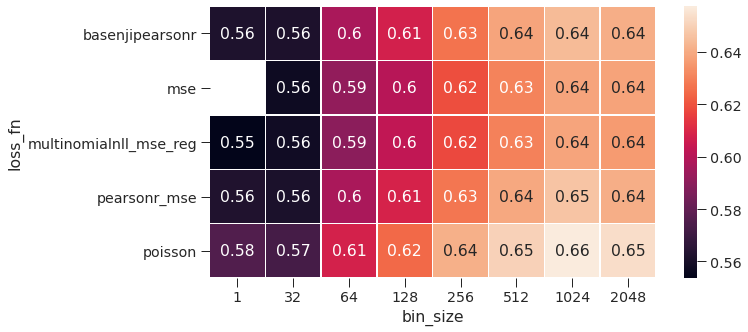

In [127]:
# piv_loss_df.set_index('loss_fn', inplace=True)
# plt.figure(figsize=[10,5])
# sns.heatmap(piv_loss_df, annot=True, linewidths=.5)

# new finetune bin loss experiment

In [2]:
summary_performance = pd.concat([pd.read_csv('summary_metrics_tables/BASENJI_BIN_LOSS.csv'), pd.read_csv('summary_metrics_tables/BASENJI_BIN_LOSS_256.csv')
])


In [3]:
average_summary_performance = summary_performance[(summary_performance['pred type'] == 'scaled')&
                                                  (summary_performance['eval type'] == 'whole')
                                                  ].groupby(['bin_size', 'loss_fn']).mean().reset_index()

In [4]:
loss_name_subs = {'basenjipearsonr': 'pearson r', 'mse': 'MSE',
                  'multinomialnll_mse_reg':'multinomial NLL + MSE',
                 'poisson':'poisson NLL', 'pearsonr_mse': 'pearson r + MSE'}

average_summary_performance['loss'] = [loss_name_subs[l] for l in average_summary_performance['loss_fn'].values]

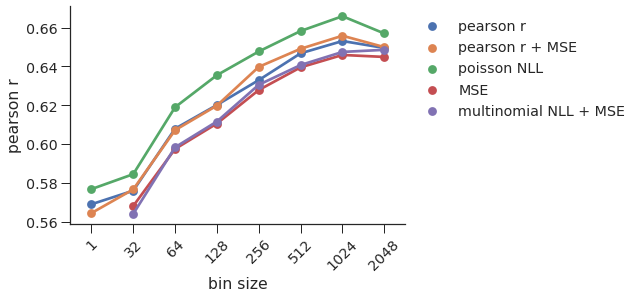

In [5]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
sns.pointplot(data=average_summary_performance, x='bin_size', y='pr', hue='loss')
plt.xticks(rotation=45);
plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('bin size')
plt.ylabel('pearson r')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.tight_layout()
plt.savefig('plots/bin_loss_basenji.svg', bbox_inches="tight")

In [6]:
average_summary_performance.head()

,bin_size,loss_fn,index,mse,js_per_seq,js_conc,poiss,pr,l_rate,num_epochs,window_size,loss
0,1,basenjipearsonr,7,1.370937,0.170732,0.216082,0.317168,0.568953,0.001,100,2048,pearson r
1,1,pearsonr_mse,7,1.506963,0.195851,0.242553,0.351620,0.564400,0.001,100,2048,pearson r + MSE
2,1,poisson,7,1.469005,0.169881,0.228024,0.341187,0.576753,0.001,100,2048,poisson NLL
3,32,basenjipearsonr,7,1.677645,0.164751,0.216260,0.416224,0.575956,0.001,100,2048,pearson r
4,32,mse,7,1.685313,0.161562,0.214074,0.417081,0.568053,0.001,100,2048,MSE


In [22]:
replicate_performance = pd.read_csv('results_tfr_evaluate/12_replicates.csv')

In [23]:
replicate_performance[replicate_performance['eval_type']=='whole']

,mse,js_per_seq,js_conc,poiss,pr_corr,sp_corr,targets,eval_bin_size,eval_type
0,0.102704,0.283116,0.220602,0.728318,0.952498,0.751889,GM23338,1,whole
2,0.097481,0.270398,0.212020,0.728592,0.954491,0.764623,GM23338,32,whole
4,0.091993,0.258415,0.203993,0.729852,0.956245,0.775926,GM23338,64,whole
6,0.080181,0.235417,0.188798,0.734056,0.959662,0.798281,GM23338,128,whole
8,0.058930,NaN,0.162385,0.744295,0.965918,0.837726,GM23338,256,whole
...,...,...,...,...,...,...,...,...,...
198,0.254800,NaN,0.343105,0.752202,0.900463,0.510567,MCF,128,whole
200,0.187921,NaN,0.302070,0.755928,0.914195,0.571109,MCF,256,whole
202,0.123005,NaN,0.251620,0.767357,0.927413,0.652783,MCF,512,whole
204,0.073489,NaN,0.198234,0.788748,0.937433,0.745988,MCF,1024,whole


In [35]:
avg_repl_performance = (replicate_performance[replicate_performance['eval_type']=='whole']).groupby(['eval_bin_size']).mean().reset_index()

In [50]:
temp_col_rename = {'eval_bin_size': 'bin_size', 'pr_corr': 'pr'}
avg_repl_performance = avg_repl_performance.rename(columns=temp_col_rename)

In [51]:
avg_repl_performance['loss'] = 'replicates'

In [52]:
avg_repl_performance

,bin_size,mse,js_per_seq,js_conc,poiss,pr,sp_corr,loss
0,1,0.280549,0.396349,0.339607,0.777643,0.871649,0.530335,replicates
1,32,0.265350,0.381380,0.328007,0.776282,0.876877,0.545997,replicates
2,64,0.249982,0.367162,0.317113,0.775667,0.881457,0.559462,replicates
3,128,0.217667,0.325169,0.296403,0.775594,0.890392,0.585900,replicates
4,256,0.161113,0.255866,0.259674,0.777956,0.906237,0.636104,replicates
5,512,0.106692,NaN,0.215238,0.785924,0.921428,0.700275,replicates
6,1024,0.063982,NaN,0.168933,0.800820,0.933618,0.770008,replicates
7,2048,0.035248,0.000000,0.126158,0.821138,0.942543,0.837466,replicates


In [25]:
# metrics_only = average_summary_performance[['mse', 'js_conc', 'poiss', 'pr']]

In [56]:
binloss_and_repl_perf = pd.concat([average_summary_performance, avg_repl_performance])[['bin_size', 'loss', 'mse', 'pr']]

Text(0.5, 0, 'MSE')

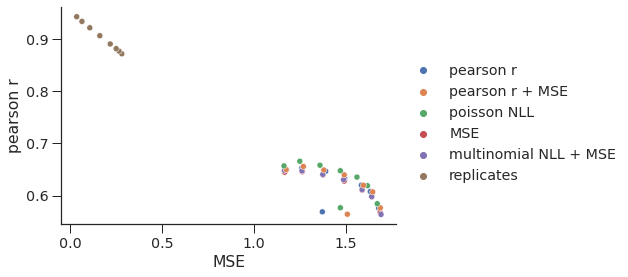

In [57]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
# s_correlation = spearmanr(average_summary_performance['mse'], average_summary_performance['pr'])[0]
# p_correlation = pearsonr(average_summary_performance['mse'], average_summary_performance['pr'])[0]

# nopearsonrloss = average_summary_performance[average_summary_performance['loss']!='pearson r']
sns.scatterplot(data=binloss_and_repl_perf, x='mse', y='pr', hue='loss')
# plt.text(1.6,0.66,'spearman r = {:.2f}\npearson r = {:.2f}'.format(s_correlation, p_correlation))
plt.legend(frameon=False, bbox_to_anchor=(1,0.8))


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel('pearson r')
plt.xlabel('MSE')

# weird 3 points

In [9]:
average_summary_performance[(average_summary_performance['mse']>1.3)&
(average_summary_performance['mse']<1.6)&
(average_summary_performance['pr']<0.6)]

,bin_size,loss_fn,index,mse,js_per_seq,js_conc,poiss,pr,l_rate,num_epochs,window_size,loss
0,1,basenjipearsonr,7,1.370937,0.170732,0.216082,0.317168,0.568953,0.001,100,2048,pearson r
1,1,pearsonr_mse,7,1.506963,0.195851,0.242553,0.351620,0.564400,0.001,100,2048,pearson r + MSE
2,1,poisson,7,1.469005,0.169881,0.228024,0.341187,0.576753,0.001,100,2048,poisson NLL


In [9]:
# get testset
data_dir='/home/shush/profile/QuantPred/datasets/chr8/complete/random_chop/i_2048_w_1/'
sts = util.load_stats(data_dir)
testset = util.make_dataset(data_dir, 'test', sts, batch_size=512, shuffle=False)
targets = pd.read_csv(data_dir+'targets.txt', sep='\t')['identifier'].values

In [125]:
targets = pd.read_csv(data_dir+'targets.txt', sep='\t')['identifier'].values

In [10]:
for run_dir in collect_run_dirs('BASENJI_BIN_LOSS'):
    metadata = get_run_metadata(run_dir)
    if (128, 'poisson') == (metadata['bin_size'].values[0], metadata['loss_fn'].values[0]):
        run_128_poiss = run_dir

wandb: Currently logged in as: toneyan (use `wandb login --relogin` to force relogin)


In [11]:
ground_truth, predictions = get_true_pred(run_128_poiss, testset)

137it [00:55,  2.46it/s]


# sanity check if all cell lines behave the same

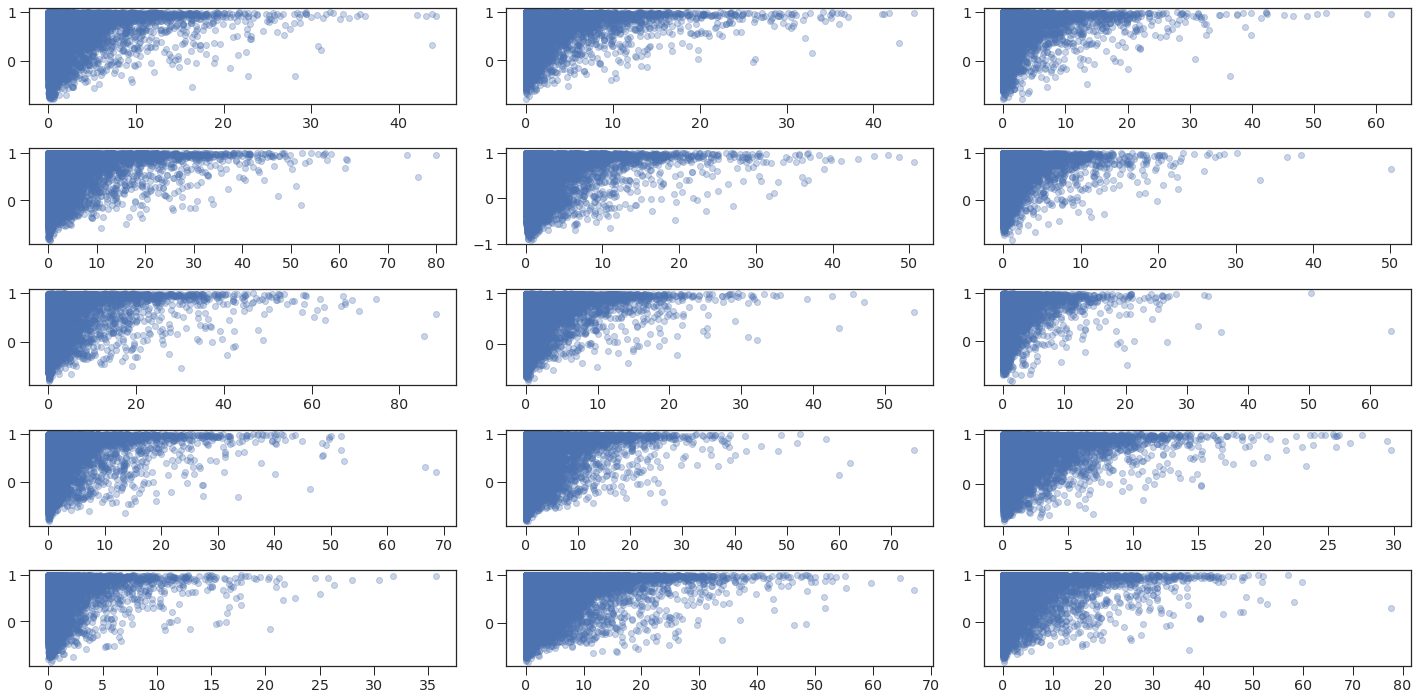

In [117]:
pr_per_seq = get_pearsonr_per_seq(ground_truth, predictions, take_avg=False)
mse_per_seq = get_mse(ground_truth, predictions)
nrows, ncols = 5, 3
fig = plt.figure(figsize=[20,10])    

for i in range(15):
    ax = fig.add_subplot(nrows, ncols, i+1)
    pr_per_seq_per_cell = pr_per_seq[i]
    mse_per_seq_per_cell = mse_per_seq[:,:,i].mean(axis=1)
    both_metrics_per_cell = np.array([mse_per_seq_per_cell, pr_per_seq_per_cell]).T
    no_nan_metrics_per_cell = both_metrics_per_cell[~np.isnan(both_metrics_per_cell).any(axis=1)]
    metrics_clean_per_cell = pd.DataFrame(no_nan_metrics_per_cell, columns=['MSE', 'pearson r'])
    ax.scatter(metrics_clean_per_cell['MSE'], metrics_clean_per_cell['pearson r'], alpha=0.3)
fig.tight_layout()

# scatterplot one cell line

In [118]:
CELL_LINE = 8
pr_per_seq = get_pearsonr_per_seq(ground_truth[:,:,CELL_LINE:(CELL_LINE+1)], predictions[:,:,CELL_LINE:(CELL_LINE+1)], take_avg=False)[0]
mse_per_seq = get_mse(ground_truth[:,:,CELL_LINE:(CELL_LINE+1)], predictions[:,:,CELL_LINE:(CELL_LINE+1)]).mean(axis=1).squeeze()
both_metrics = np.array([mse_per_seq, pr_per_seq]).T
no_nan_metrics = both_metrics[~np.isnan(both_metrics).any(axis=1)]
metrics_clean = pd.DataFrame(no_nan_metrics, columns=['MSE', 'pearson r'])

/home/shush/tf_2/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/home/shush/tf_2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


Cell line = A549
Spearman's rho = 0.03
Pearson's r = 0.08


(-2.0, 30.0)

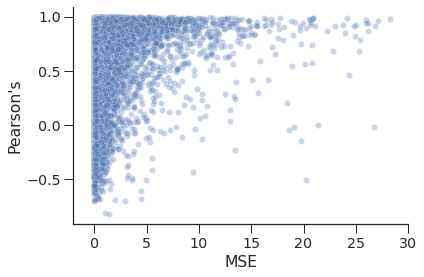

In [127]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

x = metrics_clean['MSE']
y = metrics_clean['pearson r']

sns.scatterplot(x, y, alpha=0.3)

s_correlation = spearmanr(x, y)[0]
p_correlation = pearsonr(x, y)[0]

print('Cell line = '+targets[CELL_LINE])
print('Spearman\'s rho = {:.2f}\nPearson\'s r = {:.2f}'.format(s_correlation, p_correlation))

plt.legend(frameon=False, bbox_to_anchor=(1,0.8))


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel('Pearson\'s');
plt.xlabel('MSE');
plt.xlim(-2,30)